# Time-series prediction of renewable energy production

* Use 2016-2017 for training and 2018 for testing.
* Problem framing: predict renewable energy ratio at time t based on weather forecast for time t+1.
  * For training, this means shifting weather features back one time step.

## TODO: maybe experiment with different lookbacks?

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from scipy.signal import savgol_filter

Using TensorFlow backend.
/home/johannes/.virtualenvs/renewables_notebooks/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
# fix seed to make results reproducible
np.random.seed(7)
# Ignore warning
pd.options.mode.chained_assignment = None

In [3]:
generation_data = pd.concat([
    pd.read_csv('../data/generation_2016.csv').set_index('timestamp'),
    pd.read_csv('../data/generation_2017.csv').set_index('timestamp'),    
])
    
environment_data = pd.concat([
    pd.read_csv('../data/environment_2016.csv').set_index('timestamp'),
    pd.read_csv('../data/environment_2017.csv').set_index('timestamp'),
])


In [4]:
training_data = pd.concat([generation_data, environment_data], axis=1)

In [5]:
def shift_weather_features_back(data, n):
    """
    Shift weather observations back in time. The weather observation at time t can then be interpreted
    as a forecast made at time t.
    """
    shifted = data.copy()
    shifted.wind_speed = shifted.wind_speed.shift(-n)
    shifted.temperature = shifted.temperature.shift(-n)
    shifted.cloud_cover = shifted.cloud_cover.shift(-n)
    shifted.pressure = shifted.pressure.shift(-n)
    shifted = shifted[:-n]
    return shifted


In [21]:
def _create_nonoverlapping_lookback_datasets(ds, lookback=1):
    """
    Create two datasets for training or validation: X = input, Y = output.
    X is three-dimensional: num_samples, lookback_range, num_features.
    Y is two-dimensional: num_samples, num_features. 
    The lookback argument tells us how many samples to scan back.
    """
    acc_x, acc_y = [], []
    even_n = (len(ds) // lookback) * lookback
    for i in range(0, even_n, lookback):
        acc_x.append(ds[i:i + lookback])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)

def _create_sliding_window_lookback_datasets(ds, lookback=1):
    """
    Create two datasets, similar to above, but for plotting purposes.
    """
    acc_x, acc_y = [], []
    for i in range(len(ds) - lookback):
        acc_x.append(ds[i:i + lookback])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)

def create_datasets(data, lookback=6, scaler=None):
    """
    Create X and Y datasets for training and plotting, where X is the lookback input and Y the output.
    """
    # select the columns to use for training 
    df = data[['sun', 'wind_speed', 'cloud_cover', 'temperature', 'pressure']]
    
    # the ratio is what we want to predict, and is also part of the training data
    df['ratio'] = data['renewables'] / (data['renewables'] + data['non_renewables'])
    df = df.reindex(columns=sorted(df.columns))
    df = df.reindex(columns=(['ratio'] + list([a for a in df.columns if a != 'ratio']) ))

    print('Order of columns:')
    print(df.columns)
    dataset = df.as_matrix()
    
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
    else:
        dataset = scaler.transform(dataset)

    x, y = _create_nonoverlapping_lookback_datasets(dataset, lookback)
    plot_x, plot_y = _create_sliding_window_lookback_datasets(dataset, lookback)

    # output: only the ratio (first column)
    y = y[:, 0:1]
    plot_y = plot_y[:, 0:1]
    
    return x, y, plot_x, plot_y, df.shape[1], scaler

In [22]:
training_data_shifted = shift_weather_features_back(training_data, 1)
lookback = 27
train_x, train_y, plot_x, plot_y, num_features, scaler = create_datasets(training_data_shifted, lookback)

# save scaler:
# from sklearn.externals import joblib
# scaler_filename = "scaler.save"
# joblib.dump(scaler, scaler_filename) 

Order of columns:
Index(['ratio', 'cloud_cover', 'pressure', 'sun', 'temperature', 'wind_speed'], dtype='object')


In [8]:
generation_data = pd.read_csv('../data/generation_2018.csv').set_index('timestamp')
environment_data = pd.read_csv('../data/environment_2018.csv').set_index('timestamp')
test_data = pd.concat([generation_data, environment_data], axis=1)

test_data_shifted = shift_weather_features_back(test_data, 1)
test_x, test_y, test_plot_x, test_plot_y, _, _ = create_datasets(test_data_shifted, lookback, scaler)


In [23]:
model = Sequential()
model.add(LSTM(24, input_shape=(lookback, num_features)))
model.add(Dense(1))
#model.add(LSTM(32, return_sequences=True, input_shape=(lookback, num_features)))
#model.add(Dropout(0.2))
#model.add(LSTM(32))
#model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
model.fit(train_x, train_y, epochs=80, batch_size=1, validation_data=(test_x, test_y), verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
Train on 649 samples, validate on 133 samples
Epoch 1/80
 - 12s - loss: 0.0934 - val_loss: 0.0664
Epoch 2/80
 - 11s - loss: 0.0597 - val_loss: 0.0515
Epoch 3/80
 - 11s - loss: 0.0456 - val_loss: 0.0440
Epoch 4/80
 - 11s - loss: 0.0367 - val_loss: 0.0405
Epoch 5/80
 - 11s - loss: 0.0324 - val_loss: 0.0343
Epoch 6/80
 - 11s - loss: 0.0313 - val_loss: 0.0361
Epoch 7/80
 - 11s - loss: 0.0296 - val_loss: 0.0322
Epoch 8/80
 - 11s - loss: 0.0283 - val_loss: 0.0408
Epoch 9/80
 - 11s - loss: 0.0276 - val_loss: 0.0288
Epoch 10/80
 - 11s - l

In [9]:
model = load_model('model_non_overlap_24.h5')

In [10]:
train_score = model.evaluate(train_x, train_y, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))

Train Score: 0.02 MSE (0.13 RMSE)


In [13]:
def plot_comparison(model, x, y, start=0, end=200):
    predict = model.predict(x)
    predict = list(itertools.chain.from_iterable(predict))
    plt.plot(y[start:end])
    plt.plot(savgol_filter(predict[start:end], 3, 1))
    #plt.plot(predict[start:end])
    plt.show()

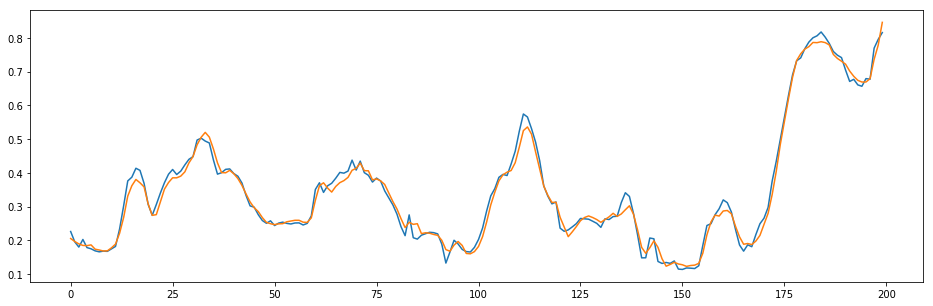

In [15]:
plot_comparison(model, plot_x, plot_y, start=1000, end=1200)

### Test with 2018 data

In [16]:
test_score = model.evaluate(test_x, test_y, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Test Score: 0.02 MSE (0.15 RMSE)


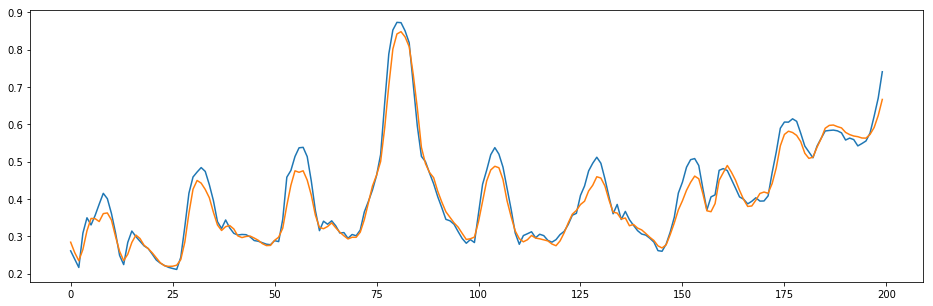

In [17]:
plot_comparison(model, test_plot_x, test_plot_y, start=1200, end=1400)

## Real-time predictions based on model constructed above

- six hours into the future
- same problem framing: weather features at time t are forecasts for t+1
- do this in app code and not here

### References

* https://keras.io/getting-started/sequential-model-guide/
* https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
